# Final Project Report: Predicting Newsletter Subscription in Minecraft Players
**Broad Question:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? <br>
**Specific Question:** How does age and play time predict the likelihood of an individual subscribing to a game-related newsletter? 

## Introduction

## Methods & Results
1. **Load Data**: Read `players.csv`.<br>
2. **Wrangle/Clean**: Impute missing values.<br>
3. **Summarize**: Compute means and proportions of subscribe.<br>
4. **Visualize**: Plot playtime and age against subscribe.<br>
5. **Analyze**: Use KNN classification to predict `subscribe` with `played_hours` and `Age`.<br>
6. **Visualize Results**: Scatterplot of predictions.<br>

In [36]:
# Load libraries
library(tidymodels)
library(dplyr)
library(ggplot2)
library(themis)

# 1. Load data
url <- "https://raw.githubusercontent.com/prabhnoor-k/DSCI-100-Project/refs/heads/main/players.csv"
players <- read.csv(url)

# 2. Wrangle and clean
players <- players |>
    select(subscribe, played_hours, Age) |>
    mutate(
        subscribe = as.factor(subscribe)  # Convert logical to factor for classification
  )

players_recipe <- recipe(~ ., data = players) |>
  step_impute_mean(Age) |>   # impute missing age
  prep()
players <- bake(players_recipe, new_data = players)

# display data
head(players)
tail(players)

# 3. Summary
summary_table <- players |>
    summarise(
        Mean_Played_Hours_for_all = mean(played_hours),
        Mean_Age_for_all = mean(Age),
        Prop_Subscribed = mean(as.numeric(subscribe) - 1))

# display the summary
summary_table

subscribe,played_hours,Age
<fct>,<dbl>,<int>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


subscribe,played_hours,Age
<fct>,<dbl>,<int>
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17
TRUE,0.2,21


Mean_Played_Hours_for_all,Mean_Age_for_all,Prop_Subscribed
<dbl>,<dbl>,<dbl>
5.845918,20.52551,0.7346939


In [7]:
# Splitting the Data 

split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(split)
players_test <- testing(split)
glimpse(players_train) #used to view data properly

Rows: 147
Columns: 3
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 1.4, 0.0, 0.0, 0.1, 0.2, 0.…
$ Age          <int> 21, 22, 17, 23, 18, 33, 25, 24, 42, 22, 37, 21, 23, 17, 1…


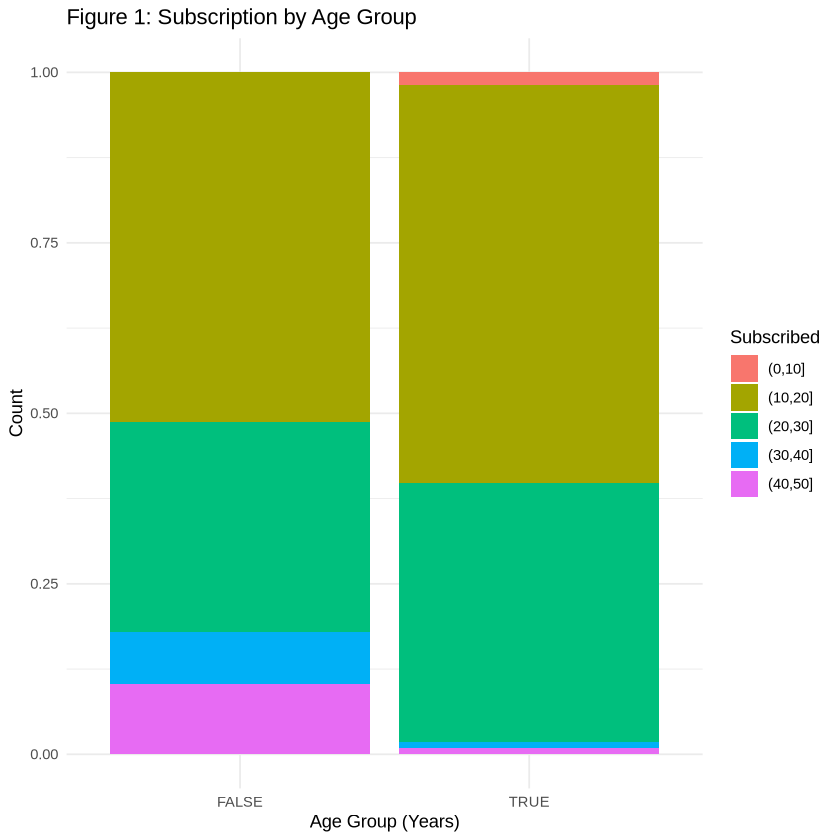

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


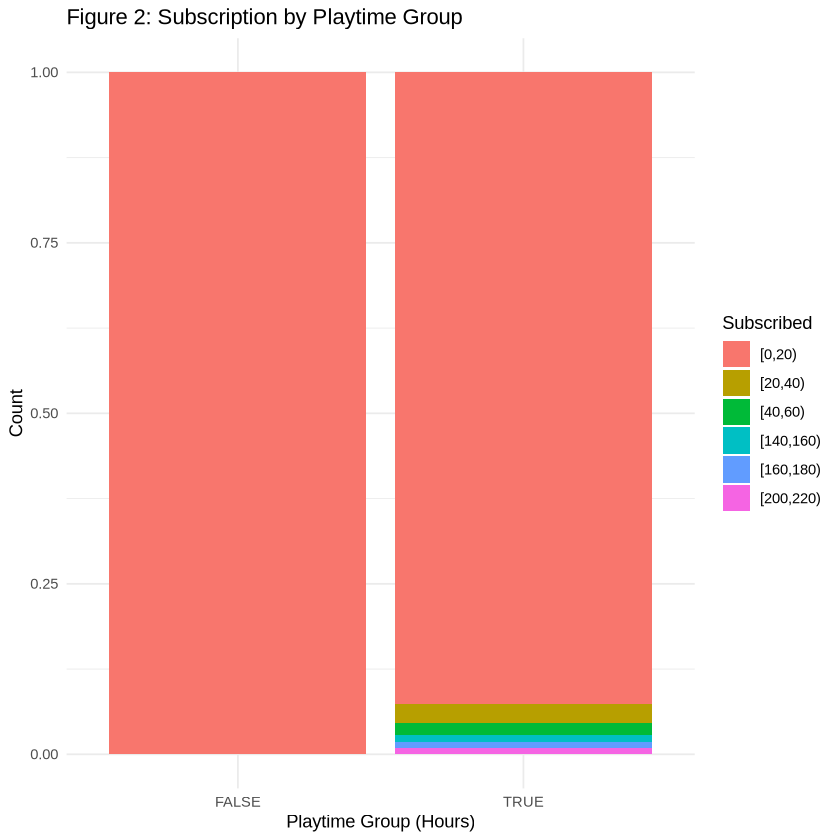

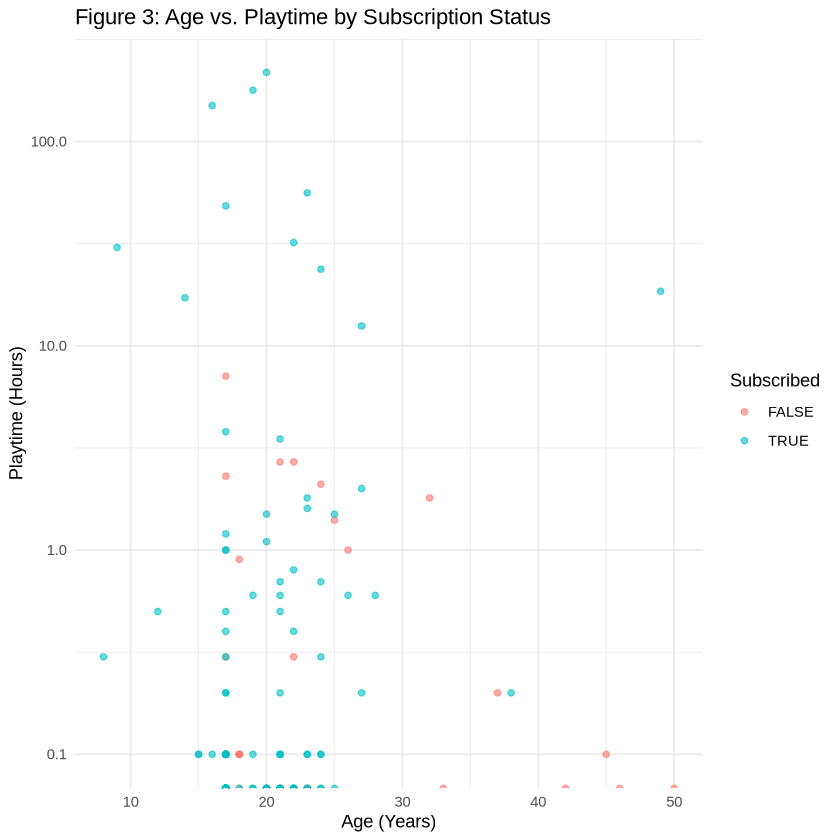

In [6]:
# 4. Visualization 


# Figure 1: Bar plot of Subscription by Age Group
age_bins <- players_train |>
    mutate(Age_Group = cut(Age, breaks = seq(0, 50, by = 10))) 
fig1 <- ggplot(age_bins, aes(x = subscribe, fill = Age_Group)) +
    geom_bar(position = "fill") +
    labs(x = "Age Group (Years)", y = "Count", 
        title = "Figure 1: Subscription by Age Group", fill = "Subscribed") +
    theme_minimal()

fig1

# Figure 2: Bar plot of Playtime vs. Subscription
playtime_bins <- players_train |>
      mutate(Playtime_Group = cut(played_hours, breaks = seq(0, 240, by = 20), right = FALSE))  
fig2 <- ggplot(playtime_bins, aes(x = subscribe, fill = Playtime_Group)) +
    geom_bar(position = "fill") +
    labs(x = "Playtime Group (Hours)", y = "Count", 
        title = "Figure 2: Subscription by Playtime Group", fill = "Subscribed") +
    theme_minimal()

fig2

# Figure 3: Scatterplot of Age vs. Playtime by Subscription
    fig3 <- ggplot(players_train, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (Years)", y = "Playtime (Hours)", 
    title = "Figure 3: Age vs. Playtime by Subscription Status", color = "Subscribed") +
    scale_y_log10()+
    theme_minimal()


fig3

In [95]:
# 5. Data Analysis with KNN

# Model Specification for Tuning 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_mode("classification") |>
            set_engine("kknn")

# Tibble for all k values
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

# Recipe with standardization
recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
  step_scale(all_predictors()) |>  
  step_center(all_predictors()) |>
  step_upsample(subscribe) # upsampling because there are too many  TRUE values

# Cross validation
data_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# Fitting data and collecting Metrics
knn_metrics <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

k_accuracies <- knn_metrics |> filter(.metric== "accuracy")
k_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5096223,5,0.03321951,Preprocessor1_Model001
2,accuracy,binary,0.4748768,5,0.04068484,Preprocessor1_Model002
3,accuracy,binary,0.4960755,5,0.03362059,Preprocessor1_Model003
4,accuracy,binary,0.5029721,5,0.03364500,Preprocessor1_Model004
5,accuracy,binary,0.4822660,5,0.03113068,Preprocessor1_Model005
6,accuracy,binary,0.4822660,5,0.03113068,Preprocessor1_Model006
7,accuracy,binary,0.5036946,5,0.02021286,Preprocessor1_Model007
8,accuracy,binary,0.5108210,5,0.02585094,Preprocessor1_Model008
9,accuracy,binary,0.5248604,5,0.02738523,Preprocessor1_Model009


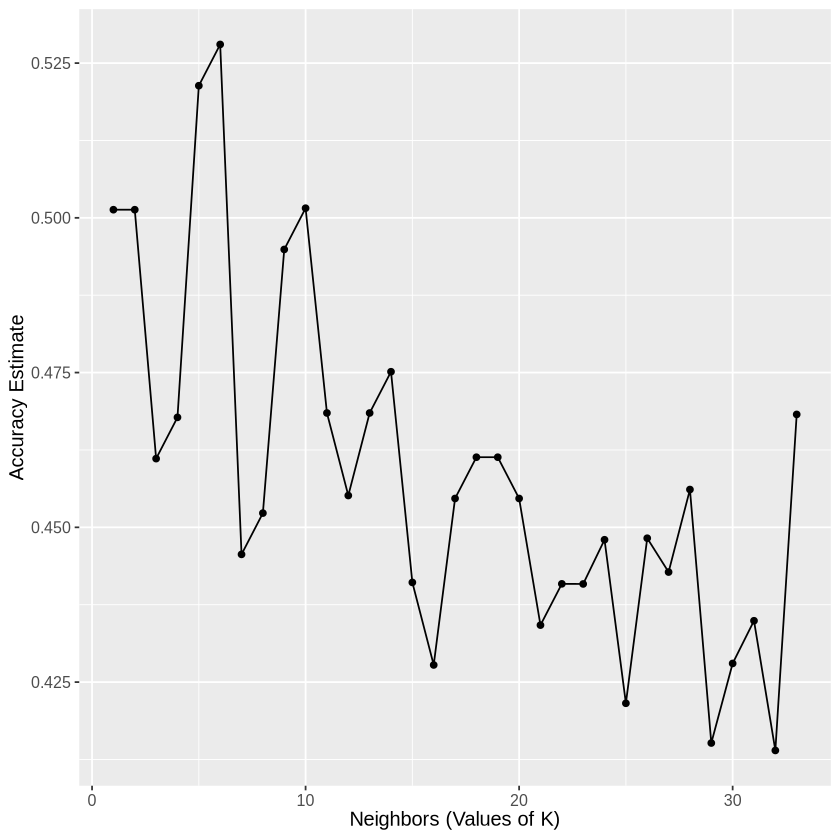

In [90]:
# Plotting graph for accuracy versus values of K 

acc_graph <- ggplot(k_accuracies , aes(x= neighbors, y= mean)) +
                    geom_point()+
                    geom_line()+
                    labs(x= "Neighbors (Values of K)", y= "Accuracy Estimate") +
                    theme(text= element_text(size=12))
acc_graph

According to the graph, we see that the best value of k occurs arround 50, now we find that.

In [92]:
# Finding best k
best_k <- k_accuracies |> arrange(desc(mean)) |> head(1) |> pull(neighbors)
best_k

[1] 6

In [93]:
# Using the value of Best K to predict

new_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
            set_mode("classification") |>
            set_engine("kknn")

# not creating a new recipe because we can use the old one.

new_fit <- workflow() |>
        add_recipe(recipe) |>
        add_model(new_spec) |>
        fit(data = players_train)

new_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3518519
Best kernel: rectangular
Best k: 6

Now, we predict using the model we created

In [94]:
# Predicting using testing data

players_predictions <- predict(new_fit, players_test) |> bind_cols(players_test)
players_predictions |> metrics(truth= subscribe, estimate = .pred_class) |>
                       filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4897959


Our model has ~74% accuracy , which means.... (CAN YOU PLEASE EXPLAIN WHAT ACCURACY HERE MEANS AND WHY IT IS GOOD FOR US)

In [88]:
# confusion matrix
confusion_matrix <- players_predictions |> conf_mat(truth = subscribe , estimate = .pred_class)
confusion_matrix 

          Truth
Prediction FALSE TRUE
     FALSE     7   19
     TRUE      6   17